In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

from tqdm import tqdm_notebook as tqdm

Data Set Information:

52 columns for 52 weeks; normalised values of provided too.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv

--2020-11-16 14:11:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/00396/Sales_Transactions_Dataset_Weekly.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317399 (310K) [application/x-httpd-php]
Saving to: ‘Sales_Transactions_Dataset_Weekly.csv.1’

Sales_Transactions_ 100%[===================>] 309.96K   598KB/s    in 0.5s    

2020-11-16 14:11:52 (598 KB/s) - ‘Sales_Transactions_Dataset_Weekly.csv.1’ saved [317399/317399]



In [ ]:
df = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
df = df.filter(regex=r'Product|W')
df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,9,3,5,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,8,12,6,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,5,5,8,7,11,7,12,6,6,5,11,8,9


In [ ]:
# W0, W1, Wn é a semana em que o produto foi negociado e quantidade de cada produto vendido
# Product_code é o código do produto vendido em cada semana

In [ ]:
df.shape

(811, 53)

### Duas abordagens comuns para modelar a previsão de demanda

  1- Criar um modelo para cada produto semana a semana (poucos dados para cada produto)

  2- Criar um modelão para todos os produtos ao mesmo tempo. Mário prefere esta abordagem
  porque aumenta a quantidade de dados, melhor para um algoritmo de ML

In [ ]:
# transformar as colunas em linhas
melt = df.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Week', 'Product_Code'])
print(melt.shape)
melt.head()

(42172, 3)


,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


### Feature Engineering

Em geral a demanda de um um dia é relacionada com a demanda dos dias anteriores ou o mesmo dia no ano anterior qual a diferença entre as vendas da semana atual para a semana anterior.

In [ ]:
melt2 = melt.copy()
melt2['Sales_Ultima_Semana'] = melt2.groupby(['Product_Code'])['Sales'].shift()
melt2['Diff_Sales_Ultima_Semana'] = melt2.groupby(['Product_Code'])['Sales_Ultima_Semana'].shift()
melt2.dropna(inplace=True)
melt2.head()

,Product_Code,Week,Sales,Sales_Ultima_Semana,Diff_Sales_Ultima_Semana
1622,1,2,10,12.0,11.0
1623,2,2,3,6.0,7.0
1624,3,2,8,11.0,7.0
1625,4,2,13,8.0,12.0
1626,5,2,13,5.0,8.0


### Baseline e Validação

In [ ]:
def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
mean_error = []
for week in range(40,52):
  # semanas anteriores ao que queremos prever para treinar o nosso modelo
  train = melt2[melt2['Week'] < week]
  # semana que queremos prever
  val   = melt2[melt2['Week'] == week]
  

  p = val['Sales_Ultima_Semana'].values

  error = rmsle(val['Sales'].values, p)
  print('Semana %d - Erro %.5f' % (week, error))
  mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

Semana 40 - Erro 0.51952
Semana 41 - Erro 0.51691
Semana 42 - Erro 0.51026
Semana 43 - Erro 0.50792
Semana 44 - Erro 0.53409
Semana 45 - Erro 0.52347
Semana 46 - Erro 0.50018
Semana 47 - Erro 0.49138
Semana 48 - Erro 0.50585
Semana 49 - Erro 0.50547
Semana 50 - Erro 0.52220
Semana 51 - Erro 0.55242
Média Erro = 0.51581


In [ ]:
# erro grande - por volta de 50%
# qualquer produto aqui tem baixa quantidade
#

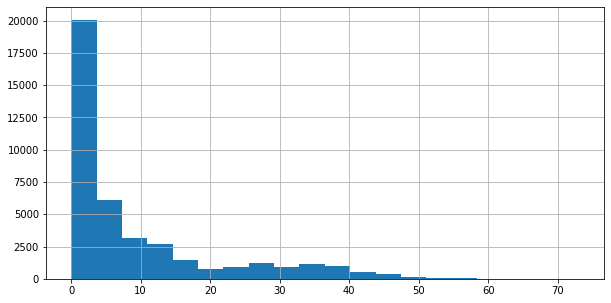

In [ ]:
# distribuição da venda dos produtos
melt2['Sales'].hist(bins=20, figsize=(10,5));

In [ ]:
# maioria dos produtos vende menos de 10 unidades por semana

### Criação do modelo

In [ ]:
mean_error = []
for week in tqdm(range(40,52)):
  train = melt2[melt2['Week'] < week]
  val   = melt2[melt2['Week'] == week]

  X_train, X_test = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
  y_train, y_test = train['Sales'].values, val['Sales'].values

  model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
  model.fit(X_train, y_train)

  p = model.predict(X_test)

  error = rmsle(y_test, p)
  print('Semana %d - Erro %.5f' % (week, error))
  mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Semana 40 - Erro 0.46050
Semana 41 - Erro 0.45704
Semana 42 - Erro 0.45655
Semana 43 - Erro 0.46604
Semana 44 - Erro 0.46579
Semana 45 - Erro 0.42733
Semana 46 - Erro 0.46422
Semana 47 - Erro 0.44914
Semana 48 - Erro 0.45315
Semana 49 - Erro 0.44638
Semana 50 - Erro 0.46694
Semana 51 - Erro 0.49053

Média Erro = 0.45863


In [ ]:
# modelo com mais variáveis - melhorar o modelo com dados da penultima semana também
melt3 = melt.copy()
melt3['Sales_Ultima_Semana'] = melt3.groupby(['Product_Code'])['Sales'].shift()
melt3['Diff_Sales_Ultima_Semana'] = melt3.groupby(['Product_Code'])['Sales_Ultima_Semana'].diff()
melt3['Sales_Ultima_Semana-1'] = melt3.groupby(['Product_Code'])['Sales'].shift(2)
melt3['Diff_Sales_Ultima_Semana-1'] = melt3.groupby(['Product_Code'])['Sales_Ultima_Semana-1'].diff()
melt3 = melt3.dropna()
melt3.head()


,Product_Code,Week,Sales,Sales_Ultima_Semana,Diff_Sales_Ultima_Semana,Sales_Ultima_Semana-1,Diff_Sales_Ultima_Semana-1
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


In [ ]:
mean_error = []
for week in tqdm(range(40,52)):
  train = melt3[melt3['Week'] < week]
  val   = melt3[melt3['Week'] == week]

  X_train, X_test = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
  y_train, y_test = train['Sales'].values, val['Sales'].values

  model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
  model.fit(X_train, y_train)

  p = model.predict(X_test)

  error = rmsle(y_test, p)
  print('Semana %d - Erro %.5f' % (week, error))
  mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Semana 40 - Erro 0.44389
Semana 41 - Erro 0.45812
Semana 42 - Erro 0.43652
Semana 43 - Erro 0.44033
Semana 44 - Erro 0.46318
Semana 45 - Erro 0.42361
Semana 46 - Erro 0.45752
Semana 47 - Erro 0.44533
Semana 48 - Erro 0.44598
Semana 49 - Erro 0.43538
Semana 50 - Erro 0.47349
Semana 51 - Erro 0.46487

Média Erro = 0.44902


In [ ]:
# adicionar as variáveis está melhorando o modelo
# continuar criando variáveis voltando semanas até o ponto em que vericarmos que 
# a pontuação não melhora mais

In [ ]:
# erro logarimico - reduzir a razão entre as previsões (erro percentual)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


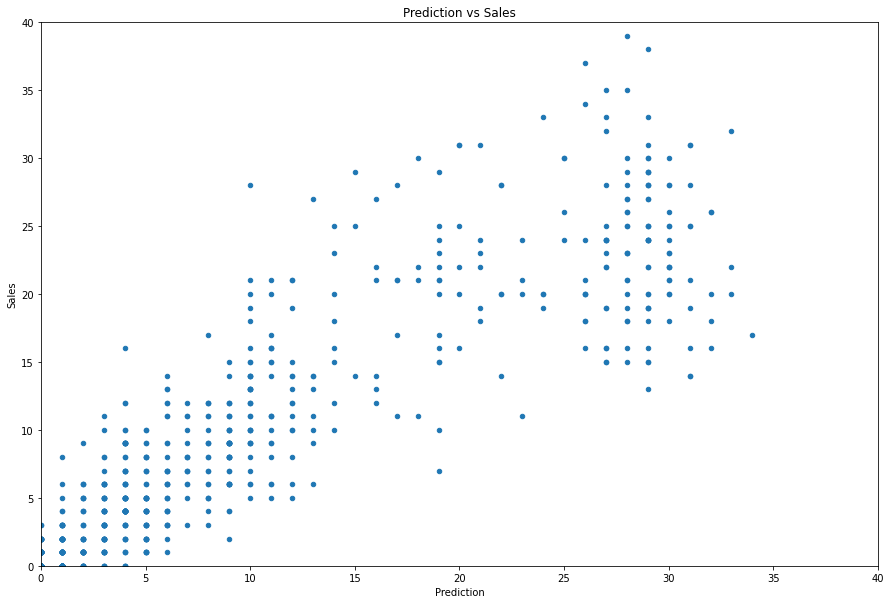

In [ ]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Sales', figsize=(15,10), title='Prediction vs Sales',
                 ylim=(0,40), xlim=(0,40))

In [ ]:
# o que fazer para melhorar o modelo?
# investigar o que esta acontecendo com os produtos que vendem mais de 25 unidades
# testar mais variáveis (lags e diferenças), não apenas no nível de produto, mas também globais
# testar modo nativo de categóricas no LightGBM
# Tunar hiperparametros
# Testar e criar rede neural e misturar com modelo atual